In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from PIL import Image
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models.resnet import ResNet
from torchvision import transforms

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [3]:
artifact_path = Path("../../artifacts/resnet")
data_path = Path("../../data/animal10")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = len(dataset.classes)

# model

In [9]:
model = ResNet(output_size=num_class, key=50).to(device)

In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
ResNet                                             --
├─Sequential: 1-1                                  --
│    └─ConvBnRelu: 2-1                             --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    └─MaxPool2d: 2-2                              --
├─Sequential: 1-2                                  --
│    └─ResBlock: 2-3                               --
│    │    └─BottleNeck: 3-4                        58,112
│    │    └─ConvBnRelu: 3-5                        16,896
│    └─ResBlock: 2-4                               --
│    │    └─BottleNeck: 3-6                        70,400
│    │    └─Identity: 3-7                          --
│    └─ResBlock: 2-5                               --
│    │    └─BottleNeck: 3-8                        70,400
│    │    └─Identity: 3-9                          --
├─S

# training

In [11]:
epoches = 10
acc_iters = 64 // BATCH_SIZE

In [12]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [13]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [40]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 1636/1636 [04:39<00:00,  5.84it/s]


epoch 1: 0.032176847903730946


100%|██████████| 1636/1636 [04:43<00:00,  5.78it/s]


epoch 2: 0.028110389810062184


100%|██████████| 1636/1636 [04:43<00:00,  5.77it/s]


epoch 3: 0.025668095604767478


100%|██████████| 1636/1636 [04:56<00:00,  5.52it/s]


epoch 4: 0.02375792081951025


100%|██████████| 1636/1636 [04:48<00:00,  5.68it/s]


epoch 5: 0.022512893380271435


100%|██████████| 1636/1636 [04:50<00:00,  5.63it/s]


epoch 6: 0.02107753414109846


100%|██████████| 1636/1636 [04:33<00:00,  5.97it/s]


epoch 7: 0.01999660179009298


100%|██████████| 1636/1636 [04:32<00:00,  6.01it/s]


epoch 8: 0.018937925457751772


100%|██████████| 1636/1636 [04:35<00:00,  5.95it/s]


epoch 9: 0.017812709400014875


100%|██████████| 1636/1636 [04:30<00:00,  6.06it/s]

epoch 10: 0.016961729453035687


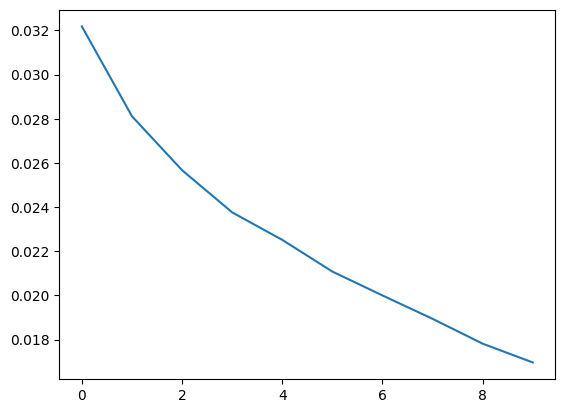

In [41]:
plt.plot(training_loss)

# inference

In [11]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [12]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [13]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [14]:
evaluator = ClassificationEvaluator(num_class, device)

In [18]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 1637/1637 [02:23<00:00, 11.43it/s]

[[4434   73   28   13   65   66   55   82   12   35]
 [ 241 2054   38   14   26   11  138   85    9    7]
 [  75   21 1197    3   19    5   23   73   15   15]
 [  32    1    3 1903   16   26    4    4   91   32]
 [ 201   12    6   42 2685   24   13   43   35   37]
 [ 489    1    6   11   18 1070    2   25   11   35]
 [ 153   74   17    5   20    3 1392  189    5    8]
 [ 139   13   28    2   35   10   79 1480   23   11]
 [ 162   13    5  203   38   38    6    8 4294   54]
 [ 181    3   14   33   32   32    1   16   41 1509]]


In [22]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.9117828500925355
cavallo   : 0.783072817384674
elefante  : 0.8278008298755186
farfalla  : 0.9010416666666666
gallina   : 0.8666881859264042
gatto     : 0.6414868105515588
mucca     : 0.7459807073954984
pecora    : 0.8131868131868132
ragno     : 0.8906865795478116
scoiattolo: 0.8104189044038668


In [23]:
per_class_acc.mean()

0.8192146165031347

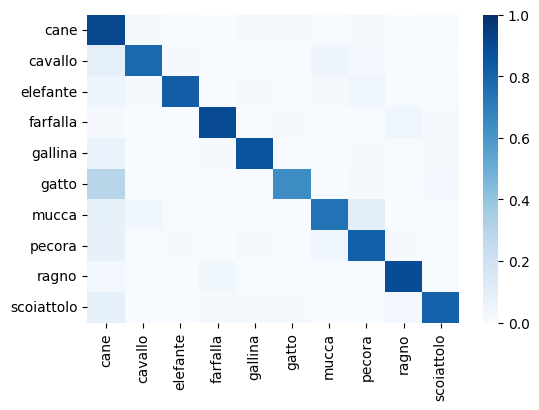

In [24]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [56]:
# image from internet
import requests
from io import BytesIO

demo_url = "http://t2.gstatic.com/licensed-image?q=tbn:ANd9GcSFoiMCj_B7I2ML4tMYIbrcSgD9gBkp-G1JVfYz8R5xtL76jjcXyhY92BwcFNKCSxCU1NwmZ5XfIAO1VCF7WCM" # cow
# demo_url = "http://t0.gstatic.com/licensed-image?q=tbn:ANd9GcRgs4mxH44aRwV3qnlSmBlnP2u4pEDu8gatItCeqvXEb3yUol302ClE9ujMszbxXiyPZopDy-3i9EzcjjLNdTI" # horse
img = Image.open(BytesIO(requests.get(demo_url).content))
img = test_preprocess(img).unsqueeze(0).to(device)

In [ ]:
# randomly sampled from dataset

# import random
# idx = random.randint(0, len(dataset))
# sample = test_dataset[idx]
# img = sample[0].unsqueeze(0).to(device)

In [57]:
model.eval()
with torch.no_grad():
    prediction = model(img).detach().cpu()
    print(dataset.classes[prediction.argmax()])
    # print(dataset.classes[sample[1]])

cane


In [15]:
model_path = artifact_path / 'resnet.pth'

In [64]:
torch.save(model.state_dict(), model_path)

In [17]:
get_file_size(model_path)

'90.06MB'

In [16]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

In [27]:
# Netron 檢查
onnx_path = artifact_path / "resnet.onnx"
torch.onnx.export(model.cpu(), torch.randn(1, 3, 224, 224), onnx_path.as_posix())